In [ ]:
# Carpeta de Google Drive
data_folder = "drive/MyDrive/MUIARFID/ALC/data/" #TASS2017_T1_test.xml TASS2017_T1_training.xml TASS2017_T1_development.xml
lib_folder = "drive/MyDrive/MUIARFID/ALC/librerias/"
res_folder = "drive/MyDrive/MUIARFID/ALC/resultados/"

In [ ]:
# Librerias
import re
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
# word_tokenize

import sklearn.feature_extraction.text as skl
# skl.CountVectorizer
# skl.HashingVectorizer
# skl.TfidfTransformer
# skl.TfidfVectorizer

from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import neighbors as neighbors_lib

# svm.LinearSVC
# svm.SVC

# External Resources
# Polarity Lexicons
# ElhPolar_esV1.lex

import sklearn.metrics 
# - classification_report, accuracy_score, precision_recall_fscore_support, etc

import xml.etree.ElementTree as ET
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize 

import scipy
import spacy

import nltk
from nltk.stem.porter import *
stemmer = PorterStemmer()

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('spanish')

import string
import numpy as np

import matplotlib.pyplot as plt

!pip install tqdm
from tqdm import tqdm
import time

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


1. Preproceso de datos

a. Train, Dev, Test en formato xml.

b. Hacer un parser (sugerencia utilizar minidom de Python):
https://docs.python.org/2/library/xml.dom.minidom.html

c. Utilizar un tokenizador

In [ ]:
# Leemos los datos

atributos = ['content']

Train = ET.parse(data_folder + 'TASS2017_T1_training.xml')
Development = ET.parse(data_folder + 'TASS2017_T1_development.xml')
Test = ET.parse(data_folder + 'TASS2017_T1_test.xml') # DOM Document

train_data = []
train_labels = []
dev_data = []
dev_labels = []
test_data = []
test_labels = []
test_ids = []

root_train = Train.getroot()
root_dev = Development.getroot()
root_test = Test.getroot()

# Tokenizer
#tokenizador = TweetTokenizer(strip_handles=False, reduce_len=True, preserve_case=False)
def mi_tokenizador(s):
  xx=[]
  x=s.split()
  for t in x:
    t = re.sub('@.*', "arroba", t)
    t = re.sub('#(.*)', "hashtag",t)
    t = re.sub('http.*', "http", t)
    t = re.sub('[0-9].*', "num", t)    
    t = re.sub('(\.{3}|[().,\'"?¿!¡…;:%-])+', "", t)
    t  = re.sub(r'\d+(.*?)(?:\u263a|\U0001f645)', "", t)
    xx.append(t)
  return (xx)

# read lexicon
def read_user_lexicon(filename):      
                
        dic = {}       

        with open(filename, 'r', encoding='utf-8') as file:
            entries = [line.split() for line in file if line.split()]            

            for tokens in entries:
                # word lowercase
                tokens[0] = tokens[0].lower()
                 

        for ent in entries:  
                   
            key = ent[0]
            if dic.get(key) == None:
              dic[key] =  ent[1]         
        
        return dic

lexicon = read_user_lexicon(lib_folder + 'ElhPolar_esV1.lex')

#Train
for tweet in root_train.findall('tweet'):  
  train_data.append(tweet.find('content').text)
  train_labels.append(tweet[5][0][0].text)

#Dev
for tweet in root_dev.findall('tweet'):  
  dev_data.append(tweet.find('content').text)    
  dev_labels.append(tweet[5][0][0].text) 

#Test
for tweet in root_test.findall('tweet'):   
  test_data.append(tweet.find('content').text)  
  test_ids.append(tweet.find('tweetid').text) 



2. Vectorizar los datos (train,dev,test)
a. Obtener una matriz de características (utilizando un vectorizer) a partir de los tweets (Hacer
selección de características)

b. Incluir recursos externos. Añadir a la matriz la información de los diccionarios de polaridad a la
matriz de características (Usando scpy, numpy,… de Python)

In [ ]:
skl_vectorizer = 'hashing' # count hashing tfid
# skl.CountVectorizer
# skl.HashingVectorizer
# skl.TfidfVectorizer

# count hashing tfid
if skl_vectorizer == 'count':
  vectorizer = skl.CountVectorizer(tokenizer = mi_tokenizador, stop_words = stop_words)
elif skl_vectorizer == 'hashing': 
  vectorizer = skl.HashingVectorizer(tokenizer = mi_tokenizador, stop_words = stop_words)
elif skl_vectorizer == 'tfid':
  vectorizer = skl.TfidfVectorizer(tokenizer = mi_tokenizador, stop_words = stop_words)
else: 
  raise ValueError("El tipo de vectorizador no existe o no se ha configurado")


train_vectors = vectorizer.fit_transform(train_data)
dev_vectors = vectorizer.transform(dev_data)
test_vectors = vectorizer.transform(test_data)


def obtenerPolaridad(palabra):
  res = None
  if lexicon.get(palabra) != None:
    res = lexicon.get(palabra)
  return res

# Trainning
longitud_train = len(train_data)
train_palabras_con_polaridad = np.zeros(shape=(longitud_train, 2))

# Se llena el array de train_palabras_con_polaridad
for idx, frase in enumerate(train_data):
  frase_tok = mi_tokenizador(frase)
  for token in frase_tok:

    polaridad = obtenerPolaridad(token)

    if polaridad != None:
      if polaridad == 'positive':
        train_palabras_con_polaridad[idx][0] += 1
      elif polaridad == 'negative':
        train_palabras_con_polaridad[idx][1] += 1

# Dev
longitud_dev = len(dev_data)
dev_palabras_con_polaridad = np.zeros(shape=(longitud_dev, 2))

# Se llena el array de train_palabras_con_polaridad
for idx, frase in enumerate(dev_data):
  frase_tok = mi_tokenizador(frase)
  for token in frase_tok:

    polaridad = obtenerPolaridad(token)

    if polaridad != None:
      if polaridad == 'positive':
        dev_palabras_con_polaridad[idx][0] += 1
      elif polaridad == 'negative':
        dev_palabras_con_polaridad[idx][1] += 1

# Test
longitud_test = len(test_data)
test_palabras_con_polaridad = np.zeros(shape=(longitud_test, 2))

# Se llena el array de train_palabras_con_polaridad
for idx, frase in enumerate(test_data):
  frase_tok = mi_tokenizador(frase)
  for token in frase_tok:

    polaridad = obtenerPolaridad(token)

    if polaridad != None:
      if polaridad == 'positive':
        test_palabras_con_polaridad[idx][0] += 1
      elif polaridad == 'negative':
        test_palabras_con_polaridad[idx][1] += 1

#Se juntan las dos matrices
train_matrix = scipy.sparse.hstack((train_vectors, train_palabras_con_polaridad))
dev_matrix = scipy.sparse.hstack((dev_vectors, dev_palabras_con_polaridad))
test_matrix = scipy.sparse.hstack((test_vectors, test_palabras_con_polaridad))


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


3. Probar con diferentes clasificadores. Entrenar con el conjunto de train y ajustar parámetros con el de
development.

In [ ]:
def argsort(seq):    
    return sorted(range(len(seq)), key=seq.__getitem__)

# SVC


100%|██████████| 4/4 [00:24<00:00,  6.15s/it]


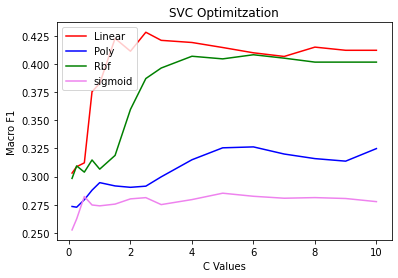


############################
Mejor resultado
############################
linear + C:  2.5  res =  0.4281
poly + C:  6.0  res =  0.3263
rbf + C:  6.0  res =  0.4081
sigmoid + C:  5.0  res =  0.2853


In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Posibles parametros
# C, The strength of the regularization is inversely proportional to C.
# kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’} or callable, default=’rbf’

#C = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1, 2]
C = [0.1, 0.25, 0.50, 0.75, 1.0, 1.50, 2.0, 2.5, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
kernels = ['rbf', 'linear', 'poly', 'sigmoid']
print('# SVC')

res = {}
linear = [] 
poly = []
rbf = []
sigmoid = []

for kernel in tqdm(kernels):
  for value in C:    
    classifier_liblinear = svm.SVC(C=value ,kernel=kernel)
    classifier_liblinear.fit(train_matrix, train_labels)
    prediction_liblinear = classifier_liblinear.predict(dev_matrix)     
    res[kernel + '_' + str(value)] = classification_report(dev_labels, prediction_liblinear, output_dict = True)['macro avg']['f1-score']

linear = [ v for k,v in res.items() if 'linear' in k]
poly = [ v for k,v in res.items() if 'poly' in k]
rbf = [ v for k,v in res.items() if 'rbf' in k]
sigmoid = [ v for k,v in res.items() if 'sigmoid' in k]

max_linear = argsort(linear)[-1]
max_poly = argsort(poly)[-1]
max_rbf = argsort(rbf)[-1]
max_sigmoid = argsort(sigmoid)[-1]


plt.plot(C, linear, color='red', label='Linear')
plt.plot(C, poly, color='blue', label='Poly')
plt.plot(C, rbf, color='green', label='Rbf')
plt.plot(C, sigmoid, color='violet', label='sigmoid')
plt.xlabel('C Values')
plt.ylabel('Macro F1')
plt.title('SVC Optimitzation')
plt.legend()
plt.show()


print('\n############################')
print('Mejor resultado')
print('############################')
print('linear + C: ', C[max_linear], ' res = ', round(linear[max_linear], 4))
print('poly + C: ', C[max_poly], ' res = ', round(poly[max_poly], 4))
print('rbf + C: ', C[max_rbf], ' res = ', round(rbf[max_rbf], 4))
print('sigmoid + C: ', C[max_sigmoid], ' res = ', round(sigmoid[max_sigmoid], 4))

In [ ]:
# Linear SVC, Tfid, Squared Hinge, C=2.0 & 0.4179
C = 2.5
kernel = 'linear'
classifier_liblinear = svm.SVC(C=C ,kernel=kernel)
classifier_liblinear.fit(train_matrix, train_labels)
prediction_liblinear = classifier_liblinear.predict(dev_matrix)     
print(classification_report(dev_labels, prediction_liblinear))


              precision    recall  f1-score   support

           N       0.63      0.62      0.62       219
         NEU       0.17      0.13      0.15        69
        NONE       0.31      0.40      0.35        62
           P       0.58      0.60      0.59       156

    accuracy                           0.52       506
   macro avg       0.42      0.44      0.43       506
weighted avg       0.51      0.52      0.52       506



# Linear SVC


100%|██████████| 2/2 [00:03<00:00,  1.75s/it]


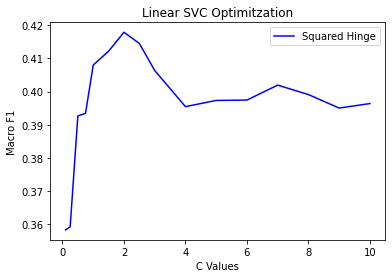


############################
Mejor resultado
############################
squared_hinge + C:  2.0  res =  0.4179


In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Posibles parametros
# 'loss' =  {'hinge', 'squared_hinge'}
# C, default=1.0

#C = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1, 2]
C = [0.1, 0.25, 0.50, 0.75, 1.0, 1.50, 2.0, 2.5, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
losses = ['hinge', 'squared_hinge']

res = {}
hinge = [] 
squared = []

print('# Linear SVC')

for loss in tqdm(losses):
  for value in C:    
    classifier_liblinear = svm.LinearSVC(C=value, tol=0.01, loss=loss, max_iter=1000000000)
    classifier_liblinear.fit(train_matrix, train_labels)
    prediction_liblinear = classifier_liblinear.predict(dev_matrix)     
    res[loss + '_' + str(value)] = classification_report(dev_labels, prediction_liblinear, output_dict = True)['macro avg']['f1-score']

hinge = [ v for k,v in res.items() if 'hinge' in k]
squared = [ v for k,v in res.items() if 'squared_hinge' in k]

max_hinge = argsort(hinge)[-1]
max_squared = argsort(squared)[-1]


plt.clf()
#plt.plot(C, hinge, color='red', label='Hinge')
plt.plot(C, squared, color='blue', label='Squared Hinge')
plt.xlabel('C Values')
plt.ylabel('Macro F1')
plt.title('Linear SVC Optimitzation')
plt.legend()
plt.show()

print('\n############################')
print('Mejor resultado')
print('############################')
#print('hinge + C: ', C[max_hinge], ' res = ', hinge[max_hinge])
print('squared_hinge + C: ', C[max_squared], ' res = ', round(squared[max_squared],4))



In [ ]:
# Linear SVC, Tfid, Squared Hinge, C=2.0 & 0.4179
C = 2.0
loss = 'squared_hinge'
classifier_liblinear = svm.LinearSVC(C=C, tol=0.01, loss=loss, max_iter=1000000000)
classifier_liblinear.fit(train_matrix, train_labels)
prediction_liblinear = classifier_liblinear.predict(dev_matrix)        
print(classification_report(dev_labels, prediction_liblinear))


              precision    recall  f1-score   support

           N       0.62      0.63      0.62       219
         NEU       0.17      0.13      0.15        69
        NONE       0.30      0.32      0.31        62
           P       0.58      0.60      0.59       156

    accuracy                           0.52       506
   macro avg       0.42      0.42      0.42       506
weighted avg       0.50      0.52      0.51       506



# Gausian


100%|██████████| 15/15 [05:21<00:00, 21.46s/it]


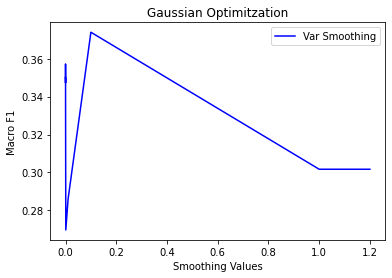


############################
Mejor resultado
############################
Smoothing:  0.1  res =  0.374


In [ ]:
import warnings
warnings.filterwarnings('ignore')
# Posibles parametros
# var_smoothing 1e-9 defecto

res = {}
smoots = [1.2, 1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-14]

print('# Gausian')
for sm in tqdm(smoots):
  classifier_liblinear = GaussianNB(var_smoothing = sm)
  classifier_liblinear.fit(train_matrix.toarray(), train_labels)
  prediction_liblinear = classifier_liblinear.predict(dev_matrix.toarray())
  res[str(sm)] = classification_report(dev_labels, prediction_liblinear, output_dict = True)['macro avg']['f1-score']

res_smoots = [v for k,v in res.items()]

max_smoots = argsort(res_smoots)[-1]

plt.clf()
plt.plot(smoots, res_smoots, color='blue', label='Var Smoothing')
plt.xlabel('Smoothing Values')
plt.ylabel('Macro F1')
plt.title('Gaussian Optimitzation')
plt.legend()
plt.show()

print('\n############################')
print('Mejor resultado')
print('############################')
print('Smoothing: ', smoots[max_smoots], ' res = ', round(res_smoots[max_smoots], 4))

In [ ]:
# Counter, Smoothing:  0.01
sm = 0.01
classifier_liblinear = GaussianNB(var_smoothing = sm)
classifier_liblinear.fit(train_matrix.toarray(), train_labels)
prediction_liblinear = classifier_liblinear.predict(dev_matrix.toarray())
print(classification_report(dev_labels, prediction_liblinear))

              precision    recall  f1-score   support

           N       0.80      0.26      0.39       219
         NEU       0.16      0.36      0.22        69
        NONE       0.26      0.60      0.36        62
           P       0.59      0.53      0.56       156

    accuracy                           0.40       506
   macro avg       0.45      0.44      0.38       506
weighted avg       0.58      0.40      0.42       506



# Gradient Boosting


100%|██████████| 20/20 [5:55:49<00:00, 1067.47s/it]


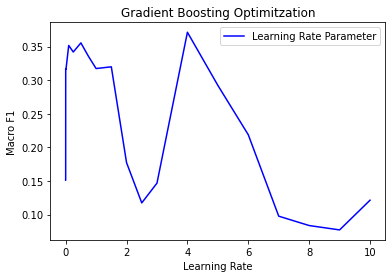


############################
Mejor resultado
############################
Learning Rate:  4.0  res =  0.3713


In [ ]:
import warnings
warnings.filterwarnings('ignore')

lrates = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.25, 0.50, 0.75, 1.0, 1.50, 2.0, 2.5, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

res = {}

print('# Gradient Boosting')

for lrate in tqdm(lrates):
  classifier_liblinear = GradientBoostingClassifier(n_estimators=1000, learning_rate=lrate, max_depth = 3, random_state = 0)
  classifier_liblinear.fit(train_matrix, train_labels)
  prediction_liblinear = classifier_liblinear.predict(dev_matrix)
  res[str(lrate)] = classification_report(dev_labels, prediction_liblinear, output_dict = True)['macro avg']['f1-score']

res_rates = [v for k,v in res.items()]

max_lr = argsort(res_rates)[-1]

plt.clf()
#plt.plot(C, hinge, color='red', label='Hinge')
plt.plot(lrates, res_rates, color='blue', label='Learning Rate Parameter')
plt.xlabel('Learning Rate')
plt.ylabel('Macro F1')
plt.title('Gradient Boosting Optimitzation')
plt.legend()
plt.show()

print('\n############################')
print('Mejor resultado')
print('############################')
print('Learning Rate: ', lrates[max_lr], ' res = ', round(res_rates[max_lr],4))

In [ ]:
# Learning Rate 0.1, Tfid & 0.3956
lrate = 1e-1

classifier_liblinear = GradientBoostingClassifier(n_estimators=1000, learning_rate=lrate, max_depth = 3, random_state = 0)
classifier_liblinear.fit(train_matrix, train_labels)
prediction_liblinear = classifier_liblinear.predict(dev_matrix)
print(classification_report(dev_labels, prediction_liblinear))

              precision    recall  f1-score   support

           N       0.60      0.67      0.64       219
         NEU       0.20      0.16      0.18        69
        NONE       0.24      0.19      0.22        62
           P       0.55      0.56      0.55       156

    accuracy                           0.51       506
   macro avg       0.40      0.40      0.40       506
weighted avg       0.49      0.51      0.50       506



# SGD


100%|██████████| 4/4 [00:00<00:00, 13.75it/s]


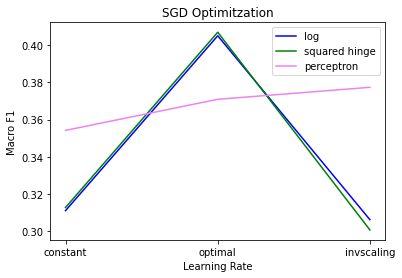


############################
Mejor resultado
############################
log + LR:  optimal  res =  0.4051
squared_hinge + LR:  optimal  res =  0.407
percepteron + LR:  invscaling  res =  0.3774


In [ ]:
import warnings
warnings.filterwarnings('ignore')

lrates = ['constant', 'optimal', 'invscaling']
losses = ['hinge', 'log', 'squared_hinge', 'perceptron']
eta0 = 1e-4

res = {}

print('# SGD')

for loss in tqdm(losses):
  for lrate in lrates:
    classifier_liblinear = SGDClassifier(loss = loss, learning_rate = lrate, eta0=eta0)
    classifier_liblinear.fit(train_matrix, train_labels)
    prediction_liblinear = classifier_liblinear.predict(dev_matrix)
    res[loss + '_' + str(lrate)] = classification_report(dev_labels, prediction_liblinear, output_dict = True)['macro avg']['f1-score']

res_hinge = [ v for k,v in res.items() if 'hinge' in k]
res_log = [ v for k,v in res.items() if 'log' in k]
res_squared_hinge = [ v for k,v in res.items() if 'squared_hinge' in k]
res_perceptron = [ v for k,v in res.items() if 'perceptron' in k]

max_hinge = argsort(res_hinge)[-1]
max_log = argsort(res_log)[-1]
max_squared_hinge = argsort(res_squared_hinge)[-1]
max_perceptron = argsort(res_perceptron)[-1]

plt.clf()
#plt.plot(lrates, res_hinge, color='red', label='hinge')
plt.plot(lrates, res_log, color='blue', label='log')
plt.plot(lrates, res_squared_hinge, color='green', label='squared hinge')
plt.plot(lrates, res_perceptron, color='violet', label='perceptron')
plt.xlabel('Learning Rate')
plt.ylabel('Macro F1')
plt.title('SGD Optimitzation')
plt.legend()
plt.show()


print('\n############################')
print('Mejor resultado')
print('############################')
#print('hinge + LR: ', lrates[max_hinge], ' res = ', res_hinge[max_hinge])
print('log + LR: ', lrates[max_log], ' res = ', round(res_log[max_log],4))
print('squared_hinge + LR: ', lrates[max_squared_hinge], ' res = ', round(res_squared_hinge[max_squared_hinge],4))
print('percepteron + LR: ', lrates[max_perceptron], ' res = ', round(res_perceptron[max_perceptron],4))

In [ ]:
lrate = 'constant'
loss = 'perceptron'
eta0 = 1e-4
classifier_liblinear = SGDClassifier(loss = loss, learning_rate = lrate, eta0=eta0)
classifier_liblinear.fit(train_matrix, train_labels)
prediction_liblinear = classifier_liblinear.predict(dev_matrix)
print(classification_report(dev_labels, prediction_liblinear))

              precision    recall  f1-score   support

           N       0.59      0.43      0.50       219
         NEU       0.14      0.17      0.16        69
        NONE       0.25      0.40      0.31        62
           P       0.53      0.55      0.54       156

    accuracy                           0.43       506
   macro avg       0.38      0.39      0.38       506
weighted avg       0.47      0.43      0.44       506



# KNN


100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


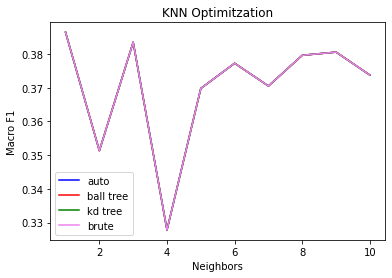


############################
Mejor resultado
############################
auto + neighbors:  1  res =  0.3865
ball tree + neighbors:  1  res =  0.3865
kd tree + neighbors:  1  res =  0.3865
brute + neighbors:  1  res =  0.3865


In [ ]:
import warnings
warnings.filterwarnings('ignore')

algorithms = ['auto', 'ball_tree', 'kd_tree', 'brute']
neighbors = [1,2,3,4,5,6,7,8,9,10]

res = {}

print('# KNN')

for alg in tqdm(algorithms):
  for nei in neighbors:
    classifier_liblinear = neighbors_lib.KNeighborsClassifier(n_neighbors = nei, algorithm=alg)  
    classifier_liblinear.fit(train_matrix, train_labels)
    prediction_liblinear = classifier_liblinear.predict(dev_matrix)
    res[alg + '_' + str(nei)] = classification_report(dev_labels, prediction_liblinear, output_dict = True)['macro avg']['f1-score']

res_auto = [ v for k,v in res.items() if 'auto' in k]
res_ball = [ v for k,v in res.items() if 'ball_tree' in k]
res_kd = [ v for k,v in res.items() if 'kd_tree' in k]
res_brute = [ v for k,v in res.items() if 'brute' in k]

max_auto = argsort(res_auto)[-1]
max_ball = argsort(res_ball)[-1]
max_kd = argsort(res_kd)[-1]
max_brute = argsort(res_brute)[-1]

plt.clf()
plt.plot(neighbors, res_auto, color='blue', label='auto')
plt.plot(neighbors, res_ball, color='red', label='ball tree')
plt.plot(neighbors, res_kd, color='green', label='kd tree')
plt.plot(neighbors, res_brute, color='violet', label='brute')
plt.xlabel('Neighbors')
plt.ylabel('Macro F1')
plt.title('KNN Optimitzation')
plt.legend()
plt.show()

print('\n############################')
print('Mejor resultado')
print('############################')
print('auto + neighbors: ', neighbors[max_auto], ' res = ', round(res_auto[max_auto],4))
print('ball tree + neighbors: ', neighbors[max_ball], ' res = ', round(res_ball[max_ball],4))
print('kd tree + neighbors: ', neighbors[max_kd], ' res = ', round(res_kd[max_kd],4))
print('brute + neighbors: ', neighbors[max_brute], ' res = ', round(res_brute[max_brute],4))

In [ ]:
# Cualquier algoritmo, Tfid, 1 vecino

alg = 'auto'
neighbors = 1
classifier_liblinear = neighbors_lib.KNeighborsClassifier(n_neighbors = neighbors, algorithm=alg)  
classifier_liblinear.fit(train_matrix, train_labels)
prediction_liblinear = classifier_liblinear.predict(dev_matrix)
print(classification_report(dev_labels, prediction_liblinear))

              precision    recall  f1-score   support

           N       0.61      0.53      0.56       219
         NEU       0.17      0.14      0.16        69
        NONE       0.23      0.37      0.28        62
           P       0.54      0.54      0.54       156

    accuracy                           0.46       506
   macro avg       0.39      0.40      0.39       506
weighted avg       0.48      0.46      0.47       506



4. Una vez elegido el mejor clasificador con los mejores parámetros, recursos, y preproceso, aplicarlo al
test.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

#VEctorización Tfid
# Mejores parámetros
C = 2.5
kernel = 'linear'
print('# SVC, Linear. C=2.5')

res = {}
linear = [] 

classifier_liblinear = svm.SVC(C=C ,kernel=kernel)
classifier_liblinear.fit(train_matrix, train_labels)
prediction_liblinear = classifier_liblinear.predict(test_matrix) 
print(prediction_liblinear)

with open(res_folder + 'JoseJavierCalvoMoratilla_SCV.txt', 'w') as f:
  for i, pred in enumerate(prediction_liblinear.tolist()):
    f.write(test_ids[i] + '\t' + pred + '\n')

# SVC, Linear. C=2.5
['NONE' 'N' 'P' ... 'NEU' 'N' 'N']


5. La salida del test, la tenéis que enviar para que os la evalúe, en un fichero texto, el nombre del fichero
que sea vuestro ‘nombre’ seguido del ‘tipo de clasificador’ (Ex. CarlosPerez_svm.txt) y el formato:
id_del_tweet \t etiqueta_polaridad (P,N,NEU,NONE)

6. Deberéis hacer una pequeña memoria que describa los clasificadores utilizados y el proceso de ajuste
realizado sobre el conjunto ‘dev’ incluyendo las tablas de los resultados en términos de P, R, F1 (clase),
Accuracy y macroF1 (global). La medida para evaluar y hacer el ranking de los sistemas será la macroF1,
por lo tanto enviad la salida del sistema que mayor macroF1 obtenga.
